In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import re
import seaborn as sns
from sklearn import decomposition
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

plt.style.use(['seaborn-darkgrid','seaborn-poster'])

%matplotlib inline

In [22]:
df = pd.read_csv('test.csv')

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
print(df.HomePlanet.unique())  #201 missing values
print(len(df.Cabin.unique()))  #199 missing values
print(df.Destination.unique()) #182 missing values
print(len(df.PassengerId.unique()))

['Europa' 'Earth' 'Mars' nan]
6561
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
8693


In [23]:
df['ID'] = [re.sub(r'_\d{2}','',i) for i in df.PassengerId] #same numbers = fa,ily or traveling together. Can ignore names now
df.drop('Name',axis=1,inplace=True)

In [24]:
c=list(df.ID.duplicated(keep=False))

df['Companion'] = list(map(int, c))

df['CDeck'] = df.Cabin.str[0]
df['CSide'] = df.Cabin.str[-1]
df['CNum'] = df.Cabin.str[2:-2]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  ID            4277 non-null   object 
 13  Companion     4277 non-null   int64  
 14  CDeck         4177 non-null   object 
 15  CSide         4177 non-null   object 
 16  CNum          4177 non-null   object 
dtypes: float64(6), int64(1), object(10)
memory usage: 568.2+ KB


In [25]:
#fixing CryoSleep null values
df.loc[((df.CryoSleep.isnull())&((df.RoomService!=0.0)|(df.FoodCourt!=0)|(df.ShoppingMall!=0.0)|(df.Spa!=0.0)|(df.VRDeck!=0.0))),'CryoSleep']=False
for i in range(len(df)):
    if pd.isna(df.CryoSleep[i]):
        if df.ID[i]==df.ID[i-1]:
            df.CryoSleep[i]=df.CryoSleep[i-1]
        elif df.ID[i]==df.ID[i+1]:
            df.CryoSleep[i]=df.CryoSleep[i+1]

df.loc[df.CryoSleep==True,'RoomService']=0.0
df.loc[df.CryoSleep==True,'FoodCourt']=0.0
df.loc[df.CryoSleep==True,'ShoppingMall']=0.0
df.loc[df.CryoSleep==True,'Spa']=0.0
df.loc[df.CryoSleep==True,'VRDeck']=0.0
df.loc[df.CryoSleep.isnull(),'CryoSleep']=True

<ipython-input-25-91c4d882fe0c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.CryoSleep[i]=df.CryoSleep[i-1]
<ipython-input-25-91c4d882fe0c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.CryoSleep[i]=df.CryoSleep[i+1]


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Transported   8693 non-null   bool   
 13  ID            8693 non-null   object 
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
df.loc[((df.RoomService.isnull()))]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,ID
35,0031_03,Mars,False,F/9/P,TRAPPIST-1e,20.0,False,NaN,0.0,1750.0,990.0,0.0,True,0031
132,0141_01,Mars,False,F/30/P,TRAPPIST-1e,31.0,False,NaN,0.0,97.0,0.0,0.0,False,0141
170,0193_02,Mars,False,F/41/P,TRAPPIST-1e,23.0,False,NaN,0.0,8.0,1072.0,0.0,False,0193
220,0234_01,Earth,False,F/50/P,TRAPPIST-1e,43.0,False,NaN,888.0,0.0,0.0,0.0,False,0234
280,0310_01,Europa,False,NaN,TRAPPIST-1e,67.0,False,NaN,230.0,0.0,4476.0,241.0,False,0310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8392,8970_01,Europa,False,C/300/P,55 Cancri e,28.0,False,NaN,3751.0,0.0,5025.0,11741.0,False,8970
8425,8998_02,Earth,False,E/591/S,TRAPPIST-1e,47.0,False,NaN,1.0,0.0,967.0,5.0,False,8998
8525,9101_01,Earth,False,F/1865/P,TRAPPIST-1e,21.0,False,NaN,0.0,496.0,430.0,0.0,False,9101
8534,9112_01,Mars,False,D/290/P,TRAPPIST-1e,28.0,False,NaN,0.0,0.0,0.0,0.0,False,9112


In [34]:
#Model CryoSleep=Transported 72% accuracy
solution=df
solution=solution[['PassengerId','CryoSleep']]
solution.rename(columns = {'CryoSleep':'Transported'}, inplace = True)
solution.to_csv('sol.csv',index=False)

/home/sferical/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


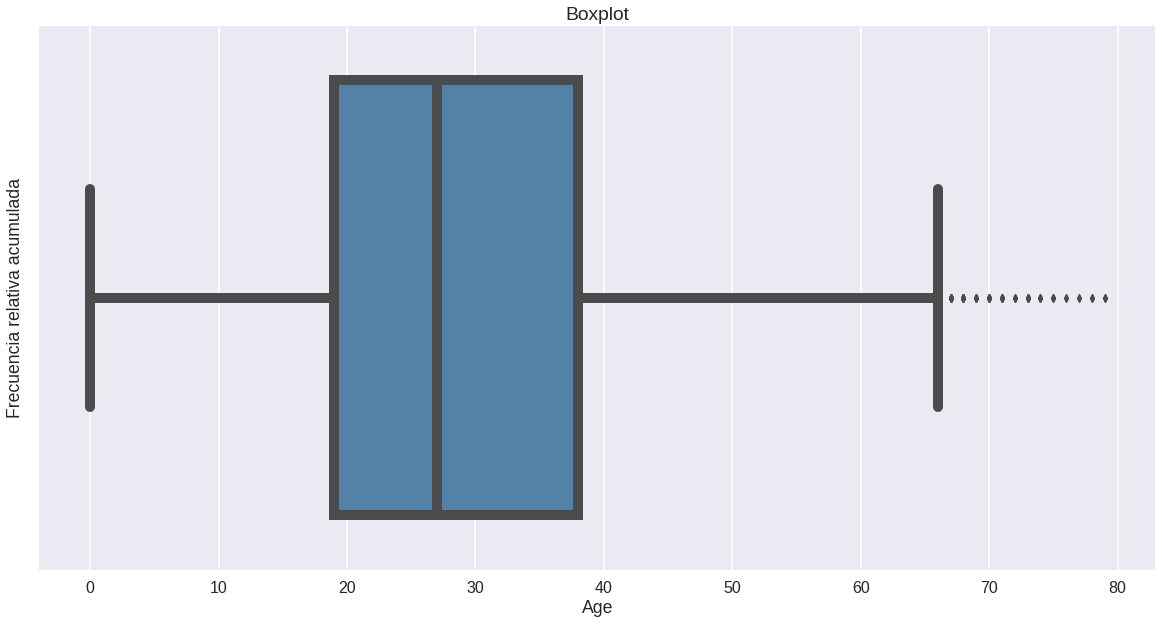

In [8]:
#EDA
fig, ax = plt.subplots(figsize = (20,10))

# Dibuja en tu canvas
_ = sns.boxplot(data = df, x = 'Age',
#                 showfliers = True,
#                 fliersize = 100,
                linewidth = 10,
                color = 'steelblue',
                ax = ax)

_ = ax.set_title('Boxplot')
_ = ax.set_xlabel('Age')
_ = ax.set_ylabel('Frecuencia relativa acumulada')

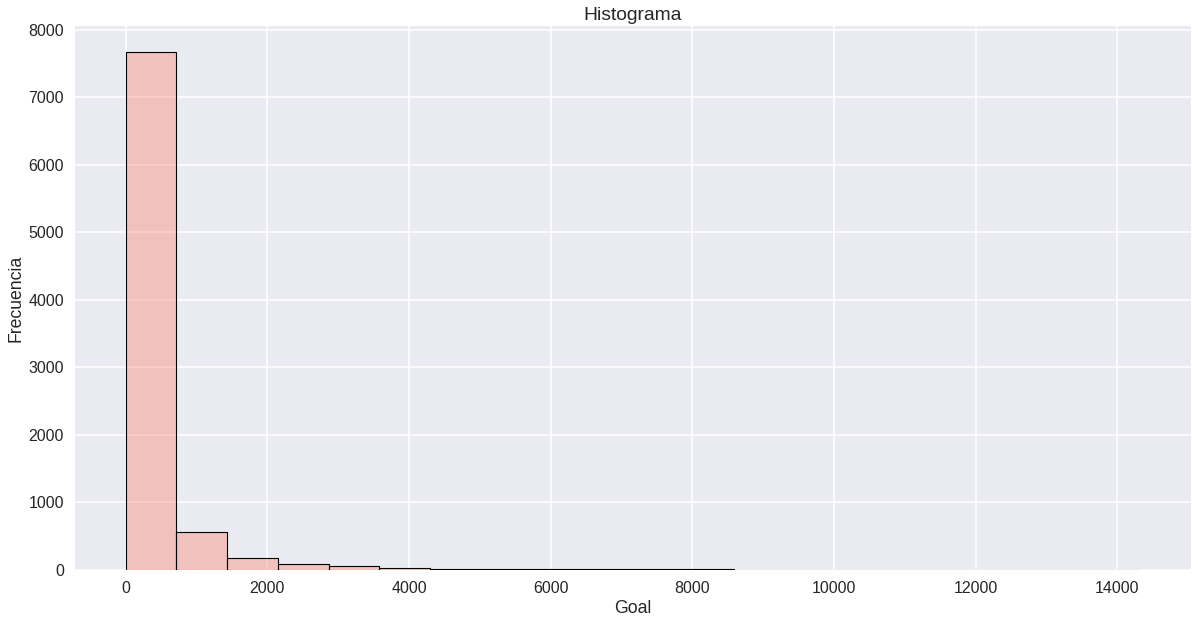

In [9]:
fig, ax = plt.subplots(figsize = (20,10))

# Dibuja en tu canvas
_ = sns.histplot(data = df, x = 'RoomService',
                bins = 20,
#                 binwidth = 1000,
#                 binrange = (1000,5000), 
                element = 'bars',
                edgecolor = 'black',
                linewidth = 1.1,
                color = 'tomato',
                alpha = .3,
#                 kde = True
                ax = ax)

_ = ax.set_title('Histograma')
_ = ax.set_xlabel('Goal')
_ = ax.set_ylabel('Frecuencia')

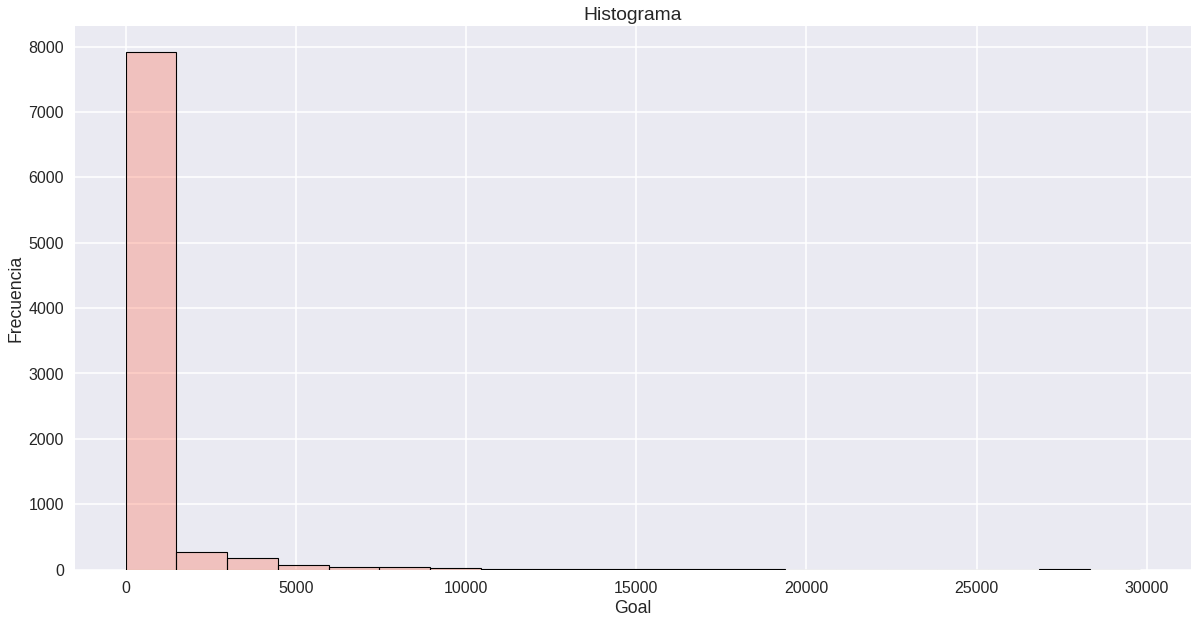

In [10]:
fig, ax = plt.subplots(figsize = (20,10))

# Dibuja en tu canvas
_ = sns.histplot(data = df, x = 'FoodCourt',
                bins = 20,
#                 binwidth = 1000,
#                 binrange = (1000,5000), 
                element = 'bars',
                edgecolor = 'black',
                linewidth = 1.1,
                color = 'tomato',
                alpha = .3,
#                 kde = True
                ax = ax)

_ = ax.set_title('Histograma')
_ = ax.set_xlabel('Goal')
_ = ax.set_ylabel('Frecuencia')

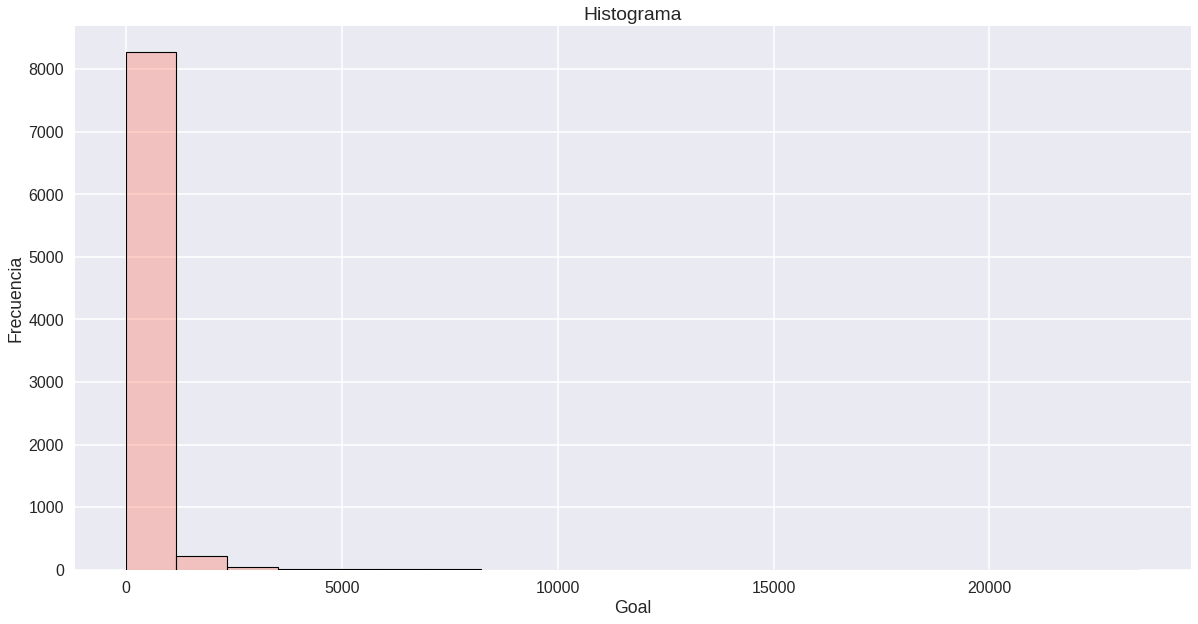

In [11]:
fig, ax = plt.subplots(figsize = (20,10))

# Dibuja en tu canvas
_ = sns.histplot(data = df, x = 'ShoppingMall',
                bins = 20,
#                 binwidth = 1000,
#                 binrange = (1000,5000), 
                element = 'bars',
                edgecolor = 'black',
                linewidth = 1.1,
                color = 'tomato',
                alpha = .3,
#                 kde = True
                ax = ax)

_ = ax.set_title('Histograma')
_ = ax.set_xlabel('Goal')
_ = ax.set_ylabel('Frecuencia')

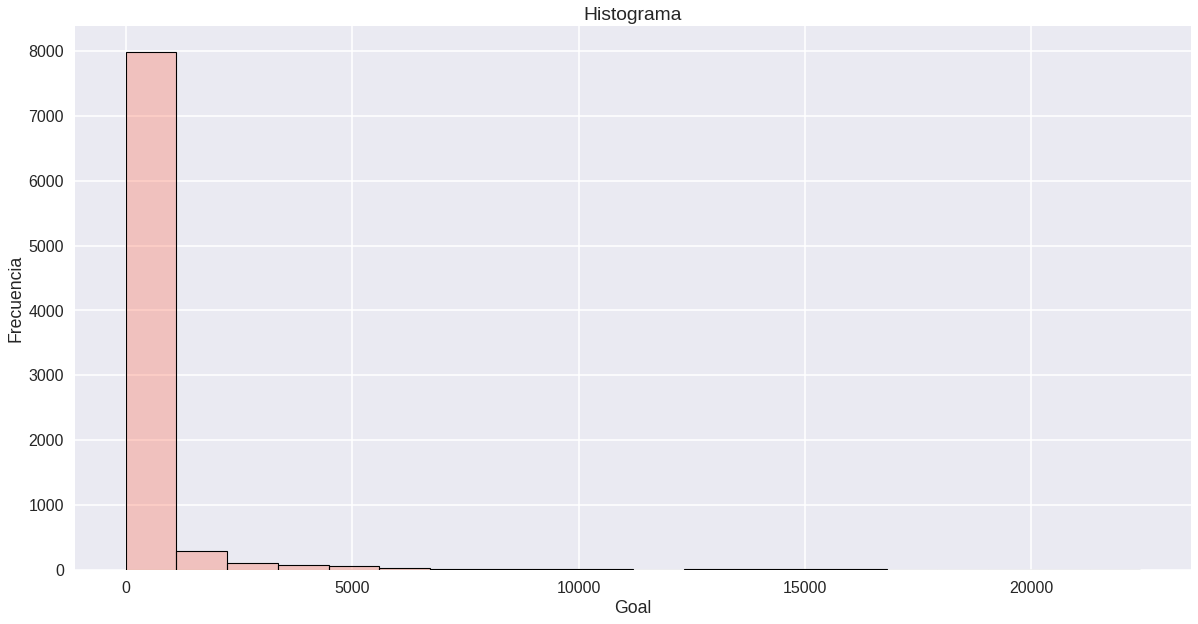

In [13]:
fig, ax = plt.subplots(figsize = (20,10))

# Dibuja en tu canvas
_ = sns.histplot(data = df, x = 'Spa',
                bins = 20,
#                 binwidth = 1000,
#                 binrange = (1000,5000), 
                element = 'bars',
                edgecolor = 'black',
                linewidth = 1.1,
                color = 'tomato',
                alpha = .3,
#                 kde = True
                ax = ax)

_ = ax.set_title('Histograma')
_ = ax.set_xlabel('Goal')
_ = ax.set_ylabel('Frecuencia')

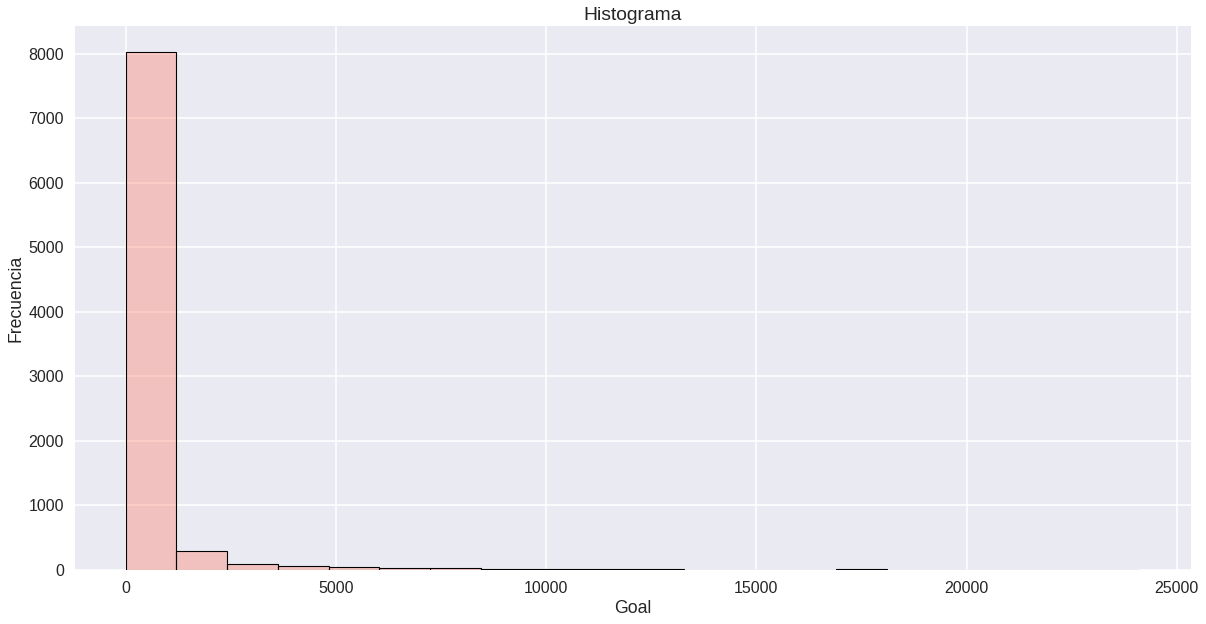

In [9]:
fig, ax = plt.subplots(figsize = (20,10))

# Dibuja en tu canvas
_ = sns.histplot(data = df, x = 'VRDeck',
                bins = 20,
#                 binwidth = 1000,
#                 binrange = (1000,5000), 
                element = 'bars',
                edgecolor = 'black',
                linewidth = 1.1,
                color = 'tomato',
                alpha = .3,
#                 kde = True
                ax = ax)

_ = ax.set_title('Histograma')
_ = ax.set_xlabel('Goal')
_ = ax.set_ylabel('Frecuencia')

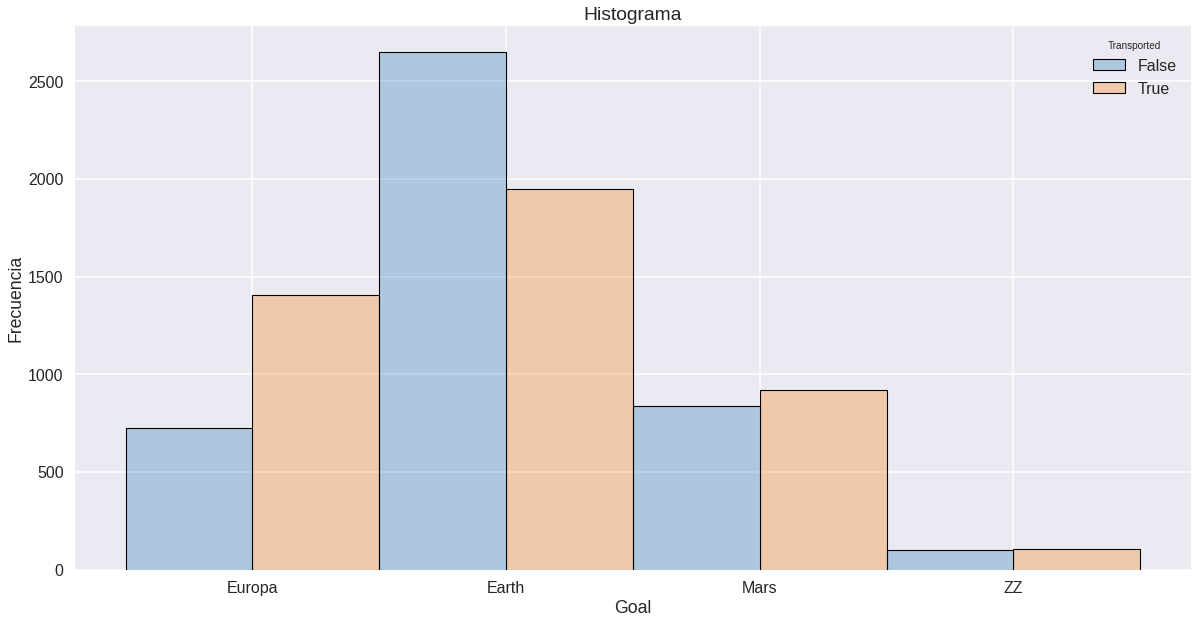

In [6]:
fig, ax = plt.subplots(figsize = (20,10))
df.HomePlanet=df.HomePlanet.fillna('ZZ')

# Dibuja en tu canvas
_ = sns.histplot(data = df, x = 'HomePlanet',
                 hue = "Transported",
#                 binwidth = 1000,
#                 binrange = (1000,5000), 
                 element = 'bars',
                 edgecolor = 'black',
                 linewidth = 1.1,
                 multiple = "dodge",                 
                 alpha = .3,
#                 kde = True
                 ax = ax)

_ = ax.set_title('Histograma')
_ = ax.set_xlabel('Goal')
_ = ax.set_ylabel('Frecuencia')

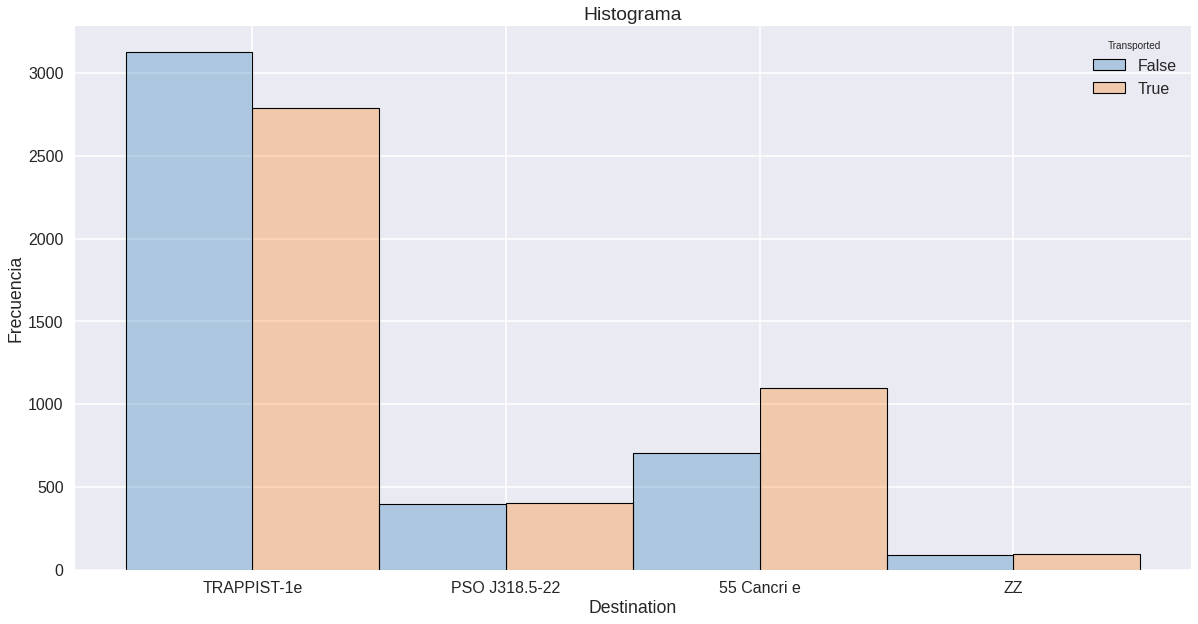

In [7]:
fig, ax = plt.subplots(figsize = (20,10))
df.Destination=df.Destination.fillna('ZZ')

# Dibuja en tu canvas
_ = sns.histplot(data = df, x = 'Destination',
                hue = "Transported",
                multiple = "dodge",
#                 binrange = (1000,5000), 
                element = 'bars',
                edgecolor = 'black',
                linewidth = 1.1,
                alpha = .3,
#                 kde = True
                ax = ax)

_ = ax.set_title('Histograma')
_ = ax.set_ylabel('Frecuencia')

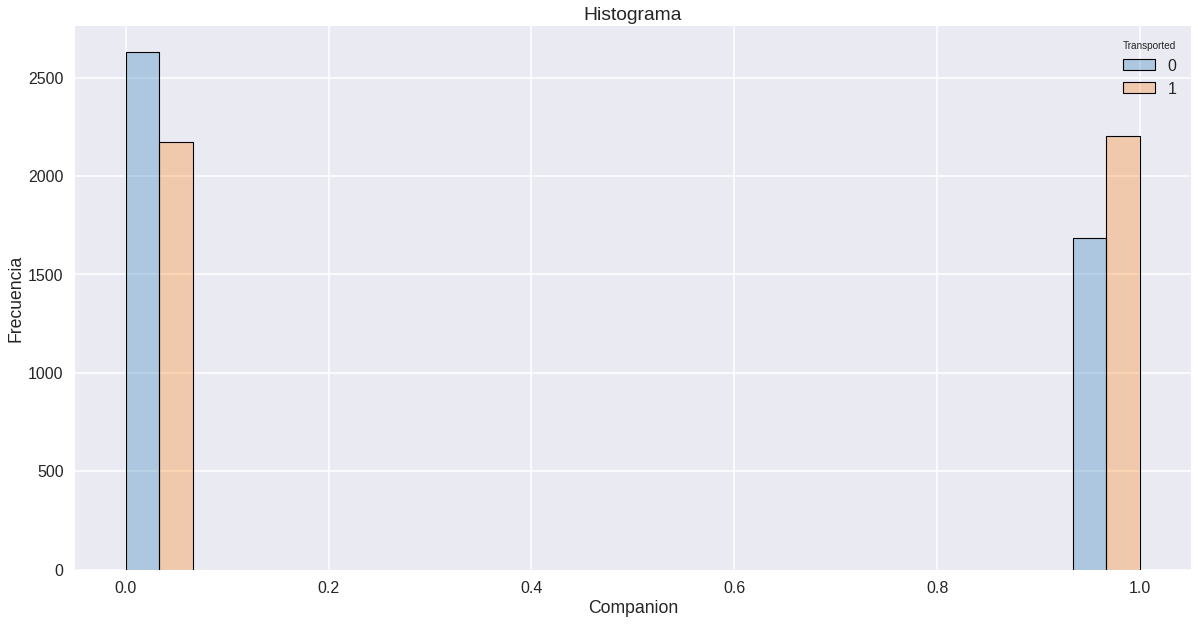

In [18]:
fig, ax = plt.subplots(figsize = (20,10))

# Dibuja en tu canvas
_ = sns.histplot(data = df, x = 'Companion',
                hue = "Transported",
                multiple = "dodge",
#                 binrange = (1000,5000), 
                element = 'bars',
                edgecolor = 'black',
                linewidth = 1.1,
                alpha = .3,
#                 kde = True
                ax = ax)

_ = ax.set_title('Histograma')
_ = ax.set_ylabel('Frecuencia')

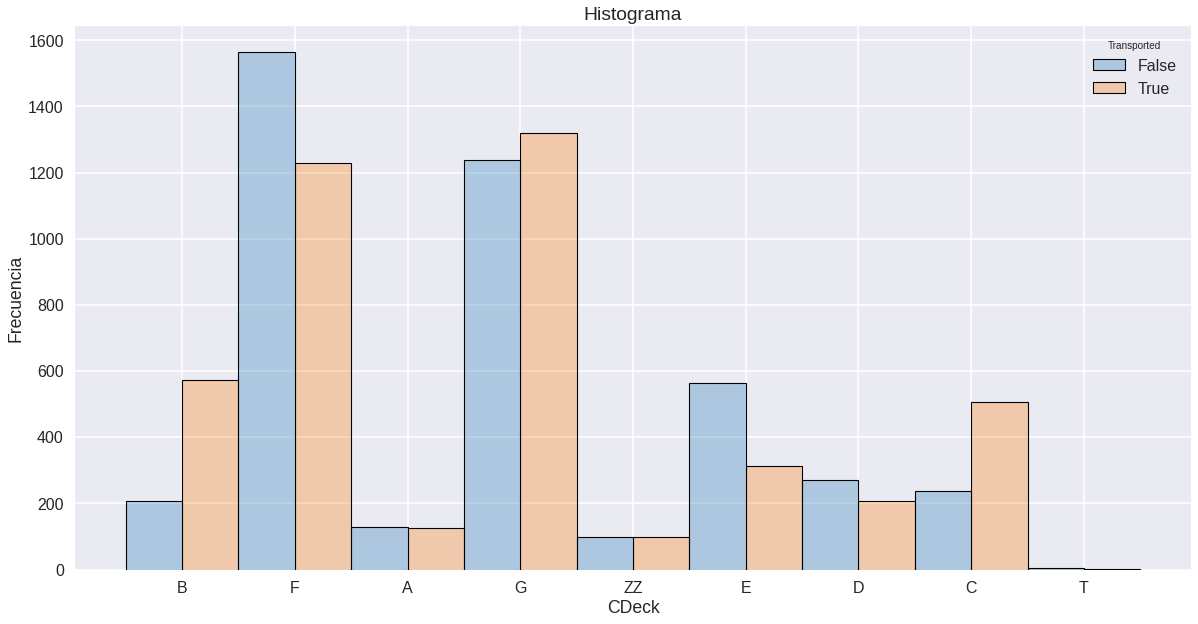

In [6]:
fig, ax = plt.subplots(figsize = (20,10))
df.CDeck=df.CDeck.fillna('ZZ')


# Dibuja en tu canvas
_ = sns.histplot(data = df, x = 'CDeck',
                hue = "Transported",
                multiple = "dodge",
#                 binrange = (1000,5000), 
                element = 'bars',
                edgecolor = 'black',
                linewidth = 1.1,
                alpha = .3,
#                 kde = True
                ax = ax)

_ = ax.set_title('Histograma')
_ = ax.set_ylabel('Frecuencia')

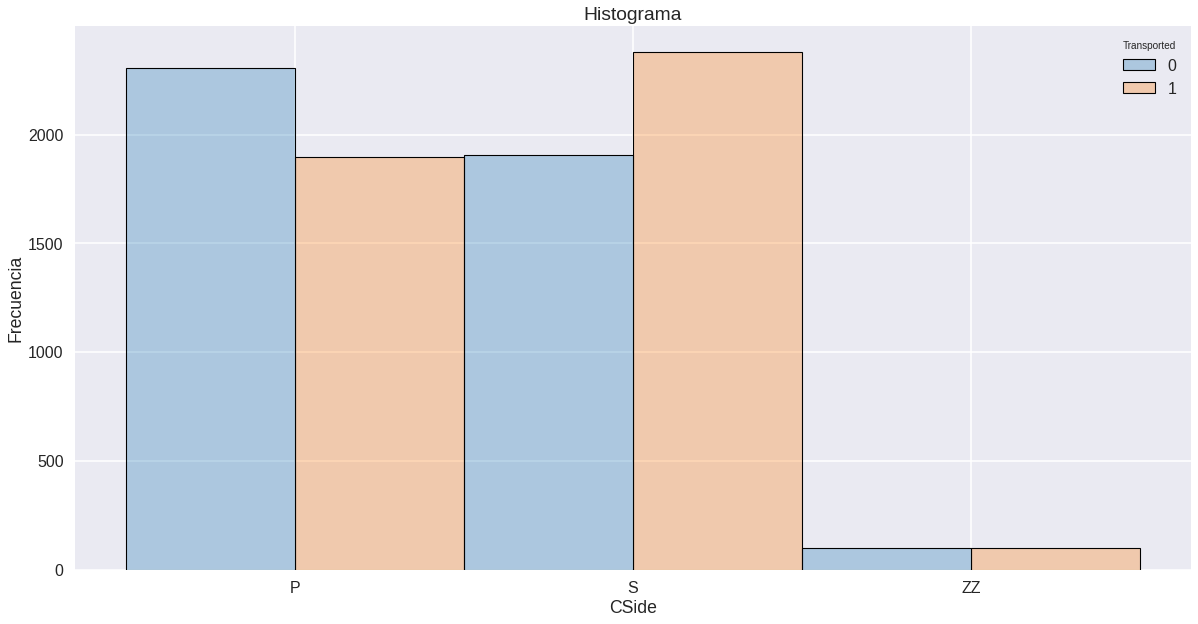

In [20]:
fig, ax = plt.subplots(figsize = (20,10))
df.CSide=df.CSide.fillna('ZZ')


# Dibuja en tu canvas
_ = sns.histplot(data = df, x = 'CSide',
                hue = "Transported",
                multiple = "dodge",
#                 binrange = (1000,5000), 
                element = 'bars',
                edgecolor = 'black',
                linewidth = 1.1,
                alpha = .3,
#                 kde = True
                ax = ax)

_ = ax.set_title('Histograma')
_ = ax.set_ylabel('Frecuencia')

In [26]:
#Replace all missing values for RoomService,FoodCourt,ShoppingMall,Spa,VRDeck for 0
df.loc[df.RoomService.isnull(),'RoomService']=0.0
df.loc[df.FoodCourt.isnull(),'FoodCourt']=0.0
df.loc[df.ShoppingMall.isnull(),'ShoppingMall']=0.0
df.loc[df.Spa.isnull(),'Spa']=0.0
df.loc[df.VRDeck.isnull(),'VRDeck']=0.0

#Replace Age with median
df.Age=df.Age.fillna(df.Age.median())

In [27]:
print(len(df.loc[df.VIP==True]))
#too little true values for VIP -> all missing values for VIP will be FALSE
df.loc[df.VIP.isnull(),'VIP']=False
print('Home')
print('Europa: ', len(df.loc[df.HomePlanet=='Europa']))
print('Earth: ', len(df.loc[df.HomePlanet=='Earth']))
print('Mars: ', len(df.loc[df.HomePlanet=='Mars']))
print('Destination')
print('TRAPPIST-1e: ', len(df.loc[df.Destination=='TRAPPIST-1e']))
print('55 Cancri e: ', len(df.loc[df.Destination=='55 Cancri e']))
print('PSO J318.5-22: ', len(df.loc[df.Destination=='PSO J318.5-22']))


74
Home
Europa:  1002
Earth:  2263
Mars:  925
Destination
TRAPPIST-1e:  2956
55 Cancri e:  841
PSO J318.5-22:  388


In [28]:
#Fill missing values of HomePlanet and Destination with respective modes.
#df.HomePlanet=df.HomePlanet.fillna('Earth')
#df.Destination=df.Destination.fillna('TRAPPIST-1e')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4277 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4277 non-null   float64
 6   VIP           4277 non-null   object 
 7   RoomService   4277 non-null   float64
 8   FoodCourt     4277 non-null   float64
 9   ShoppingMall  4277 non-null   float64
 10  Spa           4277 non-null   float64
 11  VRDeck        4277 non-null   float64
 12  ID            4277 non-null   object 
 13  Companion     4277 non-null   int64  
 14  CDeck         4177 non-null   object 
 15  CSide         4177 non-null   object 
 16  CNum          4177 non-null   object 
dtypes: float64(6), int64(1), object(10)
memory usage: 568.2+ KB


In [29]:
enc=OneHotEncoder()
enc_df_CDeck = pd.DataFrame(enc.fit_transform(df[['CDeck']]).toarray())
df = df.join(enc_df_CDeck)
df.rename(columns = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F',6:'G',7:'Ti',8:'NaNCD'}, inplace = True)
enc_df_CSide = pd.DataFrame(enc.fit_transform(df[['CSide']]).toarray())
df = df.join(enc_df_CSide)
df.rename(columns = {0:'P', 1:'S', 2:'NaNCS'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4277 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4277 non-null   float64
 6   VIP           4277 non-null   object 
 7   RoomService   4277 non-null   float64
 8   FoodCourt     4277 non-null   float64
 9   ShoppingMall  4277 non-null   float64
 10  Spa           4277 non-null   float64
 11  VRDeck        4277 non-null   float64
 12  ID            4277 non-null   object 
 13  Companion     4277 non-null   int64  
 14  CDeck         4177 non-null   object 
 15  CSide         4177 non-null   object 
 16  CNum          4177 non-null   object 
 17  A             4277 non-null   float64
 18  B             4277 non-null 

In [9]:
print(sum(df.A))
print(sum(df.B))
print(sum(df.C))
print(sum(df.D))
print(sum(df.E))
print(sum(df.F))
print(sum(df.G))
print(sum(df.P))
print(sum(df.S))
print(sum(df.Ti))


256.0
779.0
747.0
478.0
876.0
2794.0
2559.0
4206.0
4288.0
5.0


In [31]:
#Prepping Data
df.CryoSleep=list(map(int, df.CryoSleep))
df.VIP=list(map(int, df.VIP))
#df.Transported=list(map(int, df.Transported))
enc=OneHotEncoder()
enc_df_Planets = pd.DataFrame(enc.fit_transform(df[['HomePlanet']]).toarray())
df = df.join(enc_df_Planets)
df.rename(columns = {1:'Europa', 0:'Earth', 2:'Mars', 3:'NaNP'}, inplace = True)
enc_df_Destination = pd.DataFrame(enc.fit_transform(df[['Destination']]).toarray())
df = df.join(enc_df_Destination)
df.rename(columns = {1:'PSO', 0:'Cancri', 2:'Trappist', 3:'NaND'}, inplace = True)

In [19]:
df_train = df[['CryoSleep','Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Earth','Europa','Mars','Cancri','PSO','Trappist','Companion','NaNP','NaND','A','B','C','D','E','F','NaNCD','P','S','NaNCS']]
#df_train = df[['CryoSleep','Age','Spa','VRDeck','Earth','Europa','Mars','Cancri','PSO','Trappist']]
df_test = df['Transported']
int(df_test.shape[0]*.8)

6954

In [20]:
def run(x_train, y_train,x_test,y_test,clf):
    clf.fit(x_train,y_train)
    print('Score = %0.4f'% clf.score(x_test,y_test))
    print()
    
def main():
    x = df_train
    y = df_test
    np.random.seed(12345)
    idx = np.argsort(np.random.random(y.shape[0]))
    x = x.loc[idx]
    y = y.loc[idx]
    np.random.seed()
    N = int(y.shape[0]*.8)
    x_train = x[:N]
    y_train = y[:N]
    x_test = x[N:]
    y_test = y[N:]
    
    print('Nearest Centroid: ')
    run(x_train,y_train,x_test,y_test,NearestCentroid())
    print('kNN classifier (k=3):')
    run(x_train,y_train,x_test,y_test,KNeighborsClassifier(n_neighbors=3))
    print('kNN classifier (k=7):')
    run(x_train,y_train,x_test,y_test,KNeighborsClassifier(n_neighbors=7))
    print('Naive Bayes classifier(Gaussian):')
    run(x_train,y_train,x_test,y_test,GaussianNB())
    print('Decision Tree Classifier:')
    run(x_train,y_train,x_test,y_test,DecisionTreeClassifier())
    print('Random Forest Classifier (estimators=5):')
    run(x_train,y_train,x_test,y_test,RandomForestClassifier(n_estimators=5))
    print('Random Forest Classifier (estimators = 50):')
    run(x_train,y_train,x_test,y_test,RandomForestClassifier(n_estimators=200))

main()

Nearest Centroid: 
Score = 0.7332

kNN classifier (k=3):
Score = 0.7780

kNN classifier (k=7):
Score = 0.7884

Naive Bayes classifier(Gaussian):
Score = 0.7562

Decision Tree Classifier:
Score = 0.7108

Random Forest Classifier (estimators=5):
Score = 0.7631

Random Forest Classifier (estimators = 50):
Score = 0.7930



In [33]:
features = df[['CryoSleep','Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Earth','Europa','Mars','Cancri','PSO','Trappist','Companion','NaNP','NaND','A','B','C','D','E','F','NaNCD','P','S','NaNCS']]

In [21]:
clf=RandomForestClassifier(n_estimators=200)
clf.fit(df_train,df_test)

RandomForestClassifier(n_estimators=200)

In [40]:
y_pred = clf.predict(features)

In [41]:
y_pred=list(y_pred.astype(np.bool))
solution=df
solution['Transported']=y_pred
solution = solution[['PassengerId','Transported']]
solution.to_csv('sol_RF.csv',index=False)

<ipython-input-41-31558e241120>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred=list(y_pred.astype(np.bool))
